In [4]:
!pip install mahotas
!pip install scikit-learn

!pip install opencv-python

!pip install h5py

!pip install matplotlib

!pip install seaborn

!pip install -U scikit-learn
!pip install joblib


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
 

#@title imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import joblib
import sklearn.utils 
#@title Parameters
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import accuracy_score

images_per_class=800
size=tuple((500, 500))
bins =8
Training_dataset="C:/Users/Veerendra Kumar/Downloads/Project/dataset/train"
H5_TrainingData='C:/Users/Veerendra Kumar/Downloads/Project/output/train_data.h5'
H5_TrainingLabels='C:/Users/Veerendra Kumar/Downloads/Project/output/train_labels.h5'

def Modify_RGB_to_BGR(p):
    rgb_img = cv2.cvtColor(p, cv2.COLOR_BGR2RGB)
    return rgb_img
 

def Modify_BGR_to_HSV(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img
 


def Extract_Green_Brown(rgb_img,hsv_img):
    lg = np.array([25,0,20])
    ug = np.array([100,255,255])
    HMask = cv2.inRange(hsv_img, lg, ug)
     
    lb = np.array([10,0,10])
    ub = np.array([30,255,255])
    DMask = cv2.inRange(hsv_img, lb, ub)
    
    final_mask = HMask + DMask
    result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return result

#@title Features
 
def features(p):
    p = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    f = cv2.HuMoments(cv2.moments(p)).flatten()
    return f
 
def Haralick_Feature(p):
    b = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    h = mahotas.features.haralick(b).mean(axis=0)
    return h
 
def Histogram_Feature_Color(i, mask=None):
    i = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
    h  = cv2.calcHist([i], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(h, h)
    return h.flatten()

Training_Labels = os.listdir(Training_dataset)

 
Training_Labels.sort()
print(Training_Labels)

 
g_f = []
labels= []
#@title iterate on training
for training_name in Training_Labels:
    
    dir = os.path.join(Training_dataset, training_name)

    L = training_name

   
    for x in range(1,images_per_class+1):
         
        file = dir + "/" + str(x) + ".jpg"

      
        p = cv2.imread(file)
        p = cv2.resize(p, size)

        #perform on each bit
        
        RGB_BGR       = Modify_RGB_to_BGR(p)
        BGR_HSV       = Modify_BGR_to_HSV(RGB_BGR)
        IMG_SEGMENT   = Extract_Green_Brown(RGB_BGR,BGR_HSV)

        #Global_Descriptors
        
        fm = features(IMG_SEGMENT)
        fh   = Haralick_Feature(IMG_SEGMENT)
        fhist = Histogram_Feature_Color(IMG_SEGMENT)
        global_feature = np.hstack([fhist, fh, fm])
        
        
        labels.append(L)
        g_f.append(global_feature)

    print("Successfully Executed on: {}".format(L))

print("Global Feature Extraction is done")

print("feature_vector size {}".format(np.array(g_f).shape))
 
print("training_Labels {}".format(np.array(labels).shape))
 
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("training labels")


scale= MinMaxScaler(feature_range=(0, 1))
rescaled_features = scale.fit_transform(g_f)
print("Normalizing Feature Vector")
print("Target_Labels: {}".format(target))
print("Shape of Target_Labels: {}".format(target.shape))
#using HDF5 to save 
hfile = h5py.File('H5_TrainingData', 'w')
hfile.create_dataset('dataset_1', data=np.array(rescaled_features))
hla = h5py.File('H5_TrainingLabels', 'w')
hla.create_dataset('dataset_1', data=np.array(target))
hfile.close()
hla.close()

#@title Training Our Model
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
nt = 100
test_size = 0.20
seed      = 9
Training_dataset = "C:/Users/Veerendra Kumar/Downloads/Project/dataset/train"
test_path  = "C:/Users/Veerendra Kumar/Downloads/Project/dataset/test"
H5_TrainingData    = 'C:/Users/Veerendra Kumar/Downloads/Project/output/train_data.h5'
H5_TrainingLabels  = 'C:/Users/Veerendra Kumar/Downloads/Project/output/train_labels.h5'
score    = "accuracy"

Training_Labels = os.listdir(Training_dataset)

Training_Labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('Logistic_Regression', LogisticRegression(random_state=seed)))
models.append(('NaiveBayes', GaussianNB()))
models.append(('Linear_Discriminant_Analysis', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC(random_state=seed)))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('Random_Forest', RandomForestClassifier(n_estimators=nt, random_state=seed)))
models.append(('K_Nearest_Neighbours', KNeighborsClassifier()))


outputs = []
titles   = []

 
hfile  = h5py.File('H5_TrainingData', 'r')
hla = h5py.File('H5_TrainingLabels', 'r')

g_f_string = hfile['dataset_1']
g_f = np.array(g_f_string)
g_l_string   = hla['dataset_1']
g_l   = np.array(g_l_string)




hfile.close()
hla.close()

 
print("Shape of Features: {}".format(g_f.shape))
print("Shape of Labels: {}".format(g_l.shape))

print(" ***********")
 
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(g_f),
                                                                                          np.array(g_l),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print(" split train_and test data...")
print("Training_data: {}".format(trainDataGlobal.shape))
print("Testing_data: {}".format(testDataGlobal.shape)) 
trainDataGlobal
#@title 10-fold cross validation
for n, m in models:
    kfold = KFold(n_splits=10,shuffle=True, random_state=seed)
    cv_r = cross_val_score(m, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=score)
    outputs.append(cv_r)
    titles.append(n)
    display = "%s: %f (%f)" % (n, cv_r.mean(), cv_r.std())
    print(display)



['diseased', 'healthy']
Successfully Executed on: diseased
Successfully Executed on: healthy
Global Feature Extraction is done
feature_vector size (1600, 532)
training_Labels (1600,)
training labels
Normalizing Feature Vector
Target_Labels: [0 0 0 ... 1 1 1]
Shape of Target_Labels: (1600,)
Shape of Features: (1600, 532)
Shape of Labels: (1600,)
 ***********
 split train_and test data...
Training_data: (1280, 532)
Testing_data: (320, 532)
Logistic_Regression: 0.916406 (0.021833)
NaiveBayes: 0.857031 (0.010511)
Linear_Discriminant_Analysis: 0.907813 (0.019702)
SVM: 0.916406 (0.020086)
CART: 0.906250 (0.027951)
Random_Forest: 0.957031 (0.013189)
K_Nearest_Neighbours: 0.920312 (0.012500)


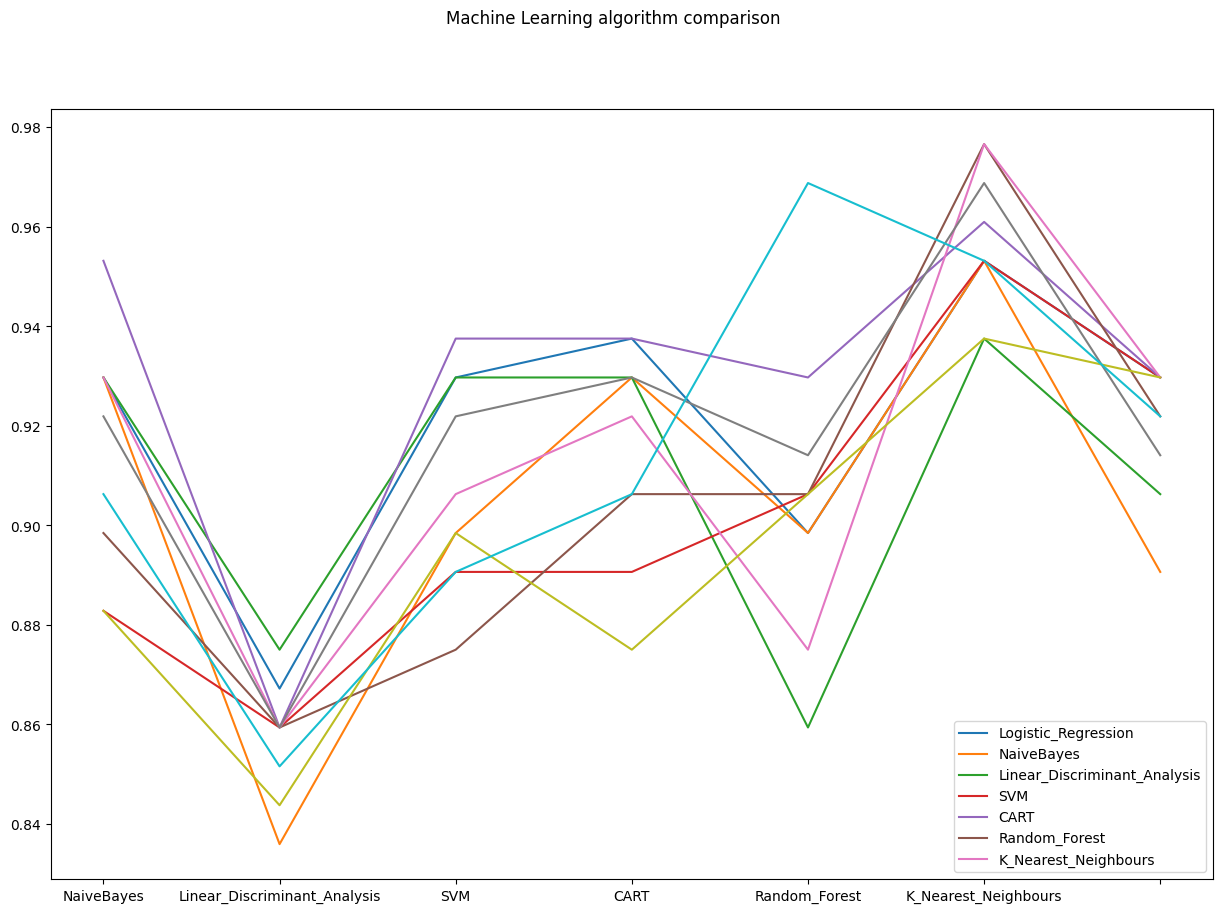

In [6]:
fig = pyplot.figure(figsize=(15,10))
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)

pyplot.plot(outputs)
ax.legend(titles)

ax.set_xticklabels(titles)
pyplot.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


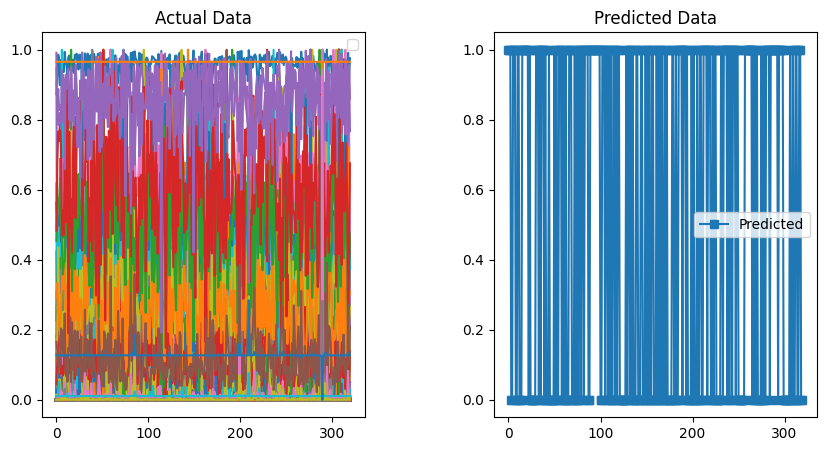

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       158
           1       0.98      0.99      0.98       162

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



0.98125

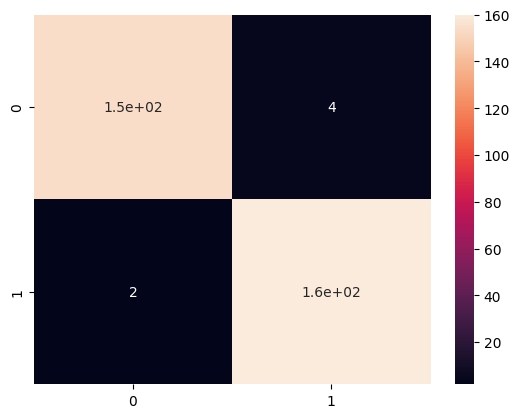

In [13]:
 
classify  = RandomForestClassifier(n_estimators=nt, random_state=seed)
 
classify.fit(trainDataGlobal, trainLabelsGlobal)
y_predict=classify.predict(testDataGlobal)
y_predict
import matplotlib.pyplot as plt

actual_data = testDataGlobal
predicted_data = y_predict
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(actual_data)
ax1.set_title('Actual Data')
ax1.legend()

ax2.plot(predicted_data, marker='s', label='Predicted')
ax2.set_title('Predicted Data')
ax2.legend()


plt.subplots_adjust(wspace=0.4)


plt.show()

 

confusion_mattrix = confusion_matrix(testLabelsGlobal,y_predict)
sns.heatmap(confusion_mattrix ,annot=True)
print(classification_report(testLabelsGlobal,y_predict))
accuracy_score(testLabelsGlobal, y_predict)